In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  70.3M      0  0:00:11  0:00:11 --:--:-- 75.7M


In [7]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

'MSR-LA - 3467.docx'   __notebook_source__.ipynb    'readme[1].txt'
 PetImages	       kagglecatsanddogs_3367a.zip


**Filter out corrupted images**

In [8]:
num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


**Generate a Dataset**

In [9]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


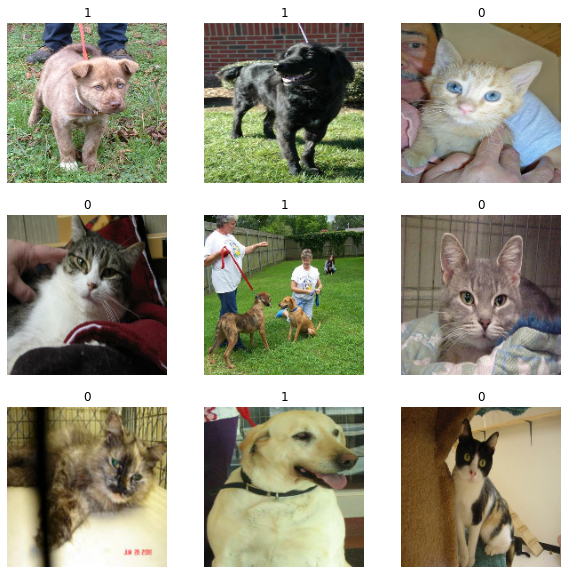

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [11]:
# data augmentation

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

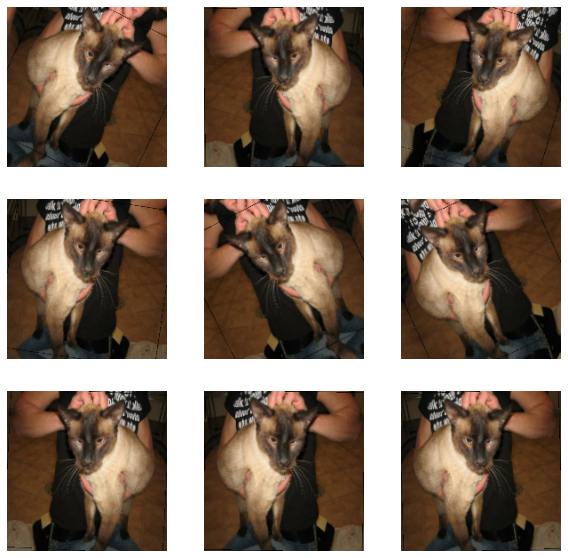

In [12]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Build Model

In [13]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

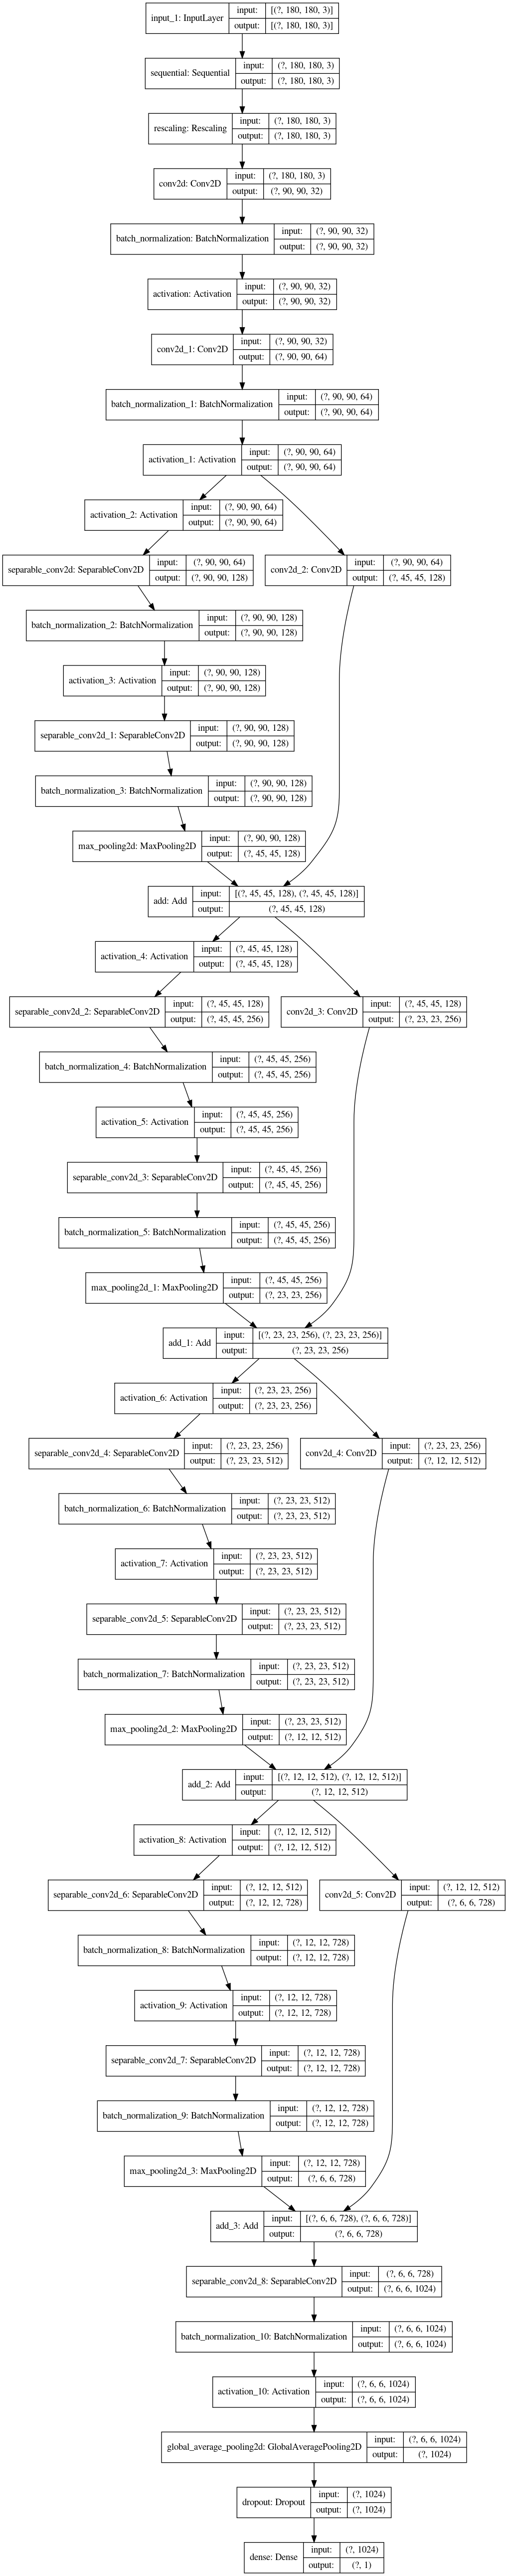

In [14]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [19]:
# Training

epochs = 50

# model check point save only best 
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5',
        verbose=1,
        monitor='val_loss',
        save_best_only=True,
        mode='auto'),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [20]:
# fit
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.8486
Epoch 00001: val_loss improved from inf to 0.34161, saving model to model-001-0.848569-0.851346.h5
586/586 [==============================] - 141s 240ms/step - loss: 0.3523 - accuracy: 0.8486 - val_loss: 0.3416 - val_accuracy: 0.8513
Epoch 2/50
586/586 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.8723
Epoch 00002: val_loss improved from 0.34161 to 0.30027, saving model to model-002-0.872330-0.868432.h5
586/586 [==============================] - 141s 241ms/step - loss: 0.3013 - accuracy: 0.8723 - val_loss: 0.3003 - val_accuracy: 0.8684
Epoch 3/50
586/586 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.8969
Epoch 00003: val_loss did not improve from 0.30027
586/586 [==============================] - 141s 241ms/step - loss: 0.2496 - accuracy: 0.8969 - val_loss: 0.3861 - val_accuracy: 0.8460
Epoch 4/50
586/586 [==============================] - 

Epoch 29/50
586/586 [==============================] - ETA: 0s - loss: 0.0802 - accuracy: 0.9687
Epoch 00029: val_loss did not improve from 0.08542
586/586 [==============================] - 141s 240ms/step - loss: 0.0802 - accuracy: 0.9687 - val_loss: 0.1004 - val_accuracy: 0.9601
Epoch 30/50
586/586 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9700
Epoch 00030: val_loss did not improve from 0.08542
586/586 [==============================] - 141s 240ms/step - loss: 0.0774 - accuracy: 0.9700 - val_loss: 0.1175 - val_accuracy: 0.9534
Epoch 31/50
586/586 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9700
Epoch 00031: val_loss did not improve from 0.08542
586/586 [==============================] - 140s 239ms/step - loss: 0.0759 - accuracy: 0.9700 - val_loss: 0.1137 - val_accuracy: 0.9607
Epoch 32/50
586/586 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9706
Epoch 00032: val_loss did not improve from 0.08542
586

In [21]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)
img_array.shape

This image is 94.48 percent cat and 5.52 percent dog.


TensorShape([1, 180, 180, 3])

In [22]:
cat_path = os.path.join("PetImages", 'Cat')
images = os.listdir(cat_path)
np.random.shuffle(images)

# check images of cats from ds

for img_path in images[:10]:
    
    full_img_path = f"{cat_path}/{img_path}"
    
    img = keras.preprocessing.image.load_img(
        full_img_path, target_size=image_size
    )
    
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array)
    score = predictions[0]
    print(
        "This image is %.2f percent cat and %.2f percent dog."
        % (100 * (1 - score), 100 * score)
    )

# images[0], cat_path

This image is 100.00 percent cat and 0.00 percent dog.
This image is 99.92 percent cat and 0.08 percent dog.
This image is 100.00 percent cat and 0.00 percent dog.
This image is 99.58 percent cat and 0.42 percent dog.
This image is 100.00 percent cat and 0.00 percent dog.
This image is 99.54 percent cat and 0.46 percent dog.
This image is 93.12 percent cat and 6.88 percent dog.
This image is 100.00 percent cat and 0.00 percent dog.
This image is 100.00 percent cat and 0.00 percent dog.
This image is 100.00 percent cat and 0.00 percent dog.


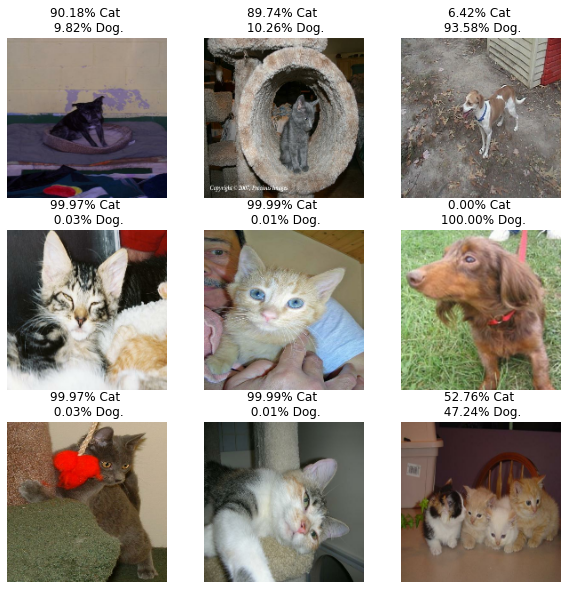

In [32]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        img_array = keras.preprocessing.image.img_to_array(images[i])
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        predictions = model.predict(img_array)
        score = predictions[0][0]
        
        plt.imshow(images[i].numpy().astype("uint8"))
        title = f"{100 * (1 - score):.2f}% Cat \n {100 * score:.2f}% Dog."
        plt.title(title)
        plt.axis("off")

In [35]:
# image from google 
# ../input/singlecat/cat-2083492_960_720.webp

cat_image = '../input/singlecat/cat-2083492_960_720.webp'

img = keras.preprocessing.image.load_img(
        cat_image, target_size=image_size
    )

img_array = keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 98.74 percent cat and 1.26 percent dog.
